# Prédiction sur des courbes simples

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Toolbox pour la génération de courbes simples

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

## Pour la fenêtre de travail sur les données

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Prédiction

Dans un premier temps on génère notre modèle, et on essaye de l'entrainer avec un callback sur le learning rate afin de trouver celui qui fonctionne le mieux.

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_daataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

2022-01-18 11:56:50.887774: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-18 11:56:50.888731: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/100
8/8 [==============================] - 1s 65ms/step - loss: 195.5726 - mae: 196.0726 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 34ms/step - loss: 194.7820 - mae: 195.2820 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 1s 23ms/step - loss: 193.5110 - mae: 194.0110 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 26ms/step - loss: 191.9081 - mae: 192.4081 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 1s 31ms/step - loss: 190.0235 - mae: 190.5235 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 29ms/step - loss: 187.8582 - mae: 188.3582 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 1s 26ms/step - loss: 185.3787 - mae: 185.8787 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 25ms/step - loss: 182.5484 - mae: 183.0484 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 1s 31ms/step - loss: 179.3126 - mae: 

Epoch 74/100
8/8 [==============================] - 0s 36ms/step - loss: 8.6197 - mae: 9.1090 - lr: 4.4668e-05
Epoch 75/100
8/8 [==============================] - 0s 29ms/step - loss: 14.6406 - mae: 15.1346 - lr: 5.0119e-05
Epoch 76/100
8/8 [==============================] - 0s 30ms/step - loss: 15.5240 - mae: 16.0183 - lr: 5.6234e-05
Epoch 77/100
8/8 [==============================] - 0s 36ms/step - loss: 15.0446 - mae: 15.5399 - lr: 6.3096e-05
Epoch 78/100
8/8 [==============================] - 1s 22ms/step - loss: 17.5174 - mae: 18.0125 - lr: 7.0795e-05
Epoch 79/100
8/8 [==============================] - 0s 35ms/step - loss: 17.1139 - mae: 17.6120 - lr: 7.9433e-05
Epoch 80/100
8/8 [==============================] - 0s 26ms/step - loss: 12.6237 - mae: 13.1192 - lr: 8.9125e-05
Epoch 81/100
8/8 [==============================] - 0s 37ms/step - loss: 19.1019 - mae: 19.5958 - lr: 1.0000e-04
Epoch 82/100
8/8 [==============================] - 0s 32ms/step - loss: 15.2565 - mae: 15.7495 - 

(1e-08, 0.0001, 0.0, 30.0)

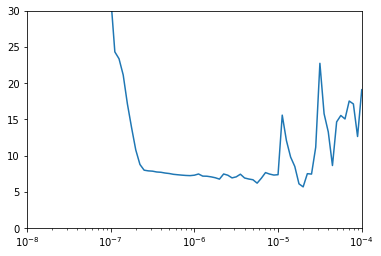

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

On utilise donc un lr ≃ 10e-6 pour entrainer le réseau.

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 32ms/step - loss: 81.7535 - mae: 82.2535
Epoch 2/400
8/8 [==============================] - 0s 32ms/step - loss: 21.9357 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 28ms/step - loss: 15.9200 - mae: 16.4144
Epoch 4/400
8/8 [==============================] - 0s 32ms/step - loss: 12.2878 - mae: 12.7813
Epoch 5/400
8/8 [==============================] - 1s 27ms/step - loss: 10.1491 - mae: 10.6393
Epoch 6/400
8/8 [==============================] - 0s 29ms/step - loss: 16.4108 - mae: 16.9057
Epoch 7/400
8/8 [==============================] - 0s 31ms/step - loss: 13.3506 - mae: 13.8434
Epoch 8/400
8/8 [==============================] - 0s 34ms/step - loss: 9.2567 - mae: 9.7490
Epoch 9/400
8/8 [==============================] - 0s 29ms/step - loss: 11.9469 - mae: 12.4386
Epoch 10/400
8/8 [==============================] - 0s 30ms/step - loss: 15.5834 - mae: 16.0771
Epoch 11/400
8/8 [==============================] -

8/8 [==============================] - 0s 29ms/step - loss: 5.1100 - mae: 5.5912
Epoch 174/400
8/8 [==============================] - 0s 24ms/step - loss: 5.2845 - mae: 5.7636
Epoch 175/400
8/8 [==============================] - 0s 31ms/step - loss: 5.1181 - mae: 5.5976
Epoch 176/400
8/8 [==============================] - 0s 41ms/step - loss: 5.0918 - mae: 5.5721
Epoch 177/400
8/8 [==============================] - 0s 36ms/step - loss: 4.8169 - mae: 5.2960
Epoch 178/400
8/8 [==============================] - 0s 34ms/step - loss: 4.5773 - mae: 5.0555
Epoch 179/400
8/8 [==============================] - 0s 27ms/step - loss: 5.3569 - mae: 5.8371
Epoch 180/400
8/8 [==============================] - 1s 24ms/step - loss: 5.4218 - mae: 5.9026
Epoch 181/400
8/8 [==============================] - 0s 29ms/step - loss: 4.2261 - mae: 4.7007
Epoch 182/400
8/8 [==============================] - 0s 29ms/step - loss: 4.6450 - mae: 5.1247
Epoch 183/400
8/8 [==============================] - 0s 28ms/ste

8/8 [==============================] - 1s 49ms/step - loss: 5.0578 - mae: 5.5387
Epoch 346/400
8/8 [==============================] - 0s 37ms/step - loss: 6.9307 - mae: 7.4171
Epoch 347/400
8/8 [==============================] - 0s 25ms/step - loss: 6.8833 - mae: 7.3686
Epoch 348/400
8/8 [==============================] - 0s 28ms/step - loss: 5.9778 - mae: 6.4607
Epoch 349/400
8/8 [==============================] - 0s 31ms/step - loss: 5.2422 - mae: 5.7225
Epoch 350/400
8/8 [==============================] - 1s 29ms/step - loss: 5.1172 - mae: 5.5974
Epoch 351/400
8/8 [==============================] - 0s 33ms/step - loss: 4.4657 - mae: 4.9455
Epoch 352/400
8/8 [==============================] - 0s 33ms/step - loss: 4.3644 - mae: 4.8410
Epoch 353/400
8/8 [==============================] - 0s 22ms/step - loss: 4.4410 - mae: 4.9171
Epoch 354/400
8/8 [==============================] - 0s 23ms/step - loss: 4.4630 - mae: 4.9353
Epoch 355/400
8/8 [==============================] - 1s 30ms/ste

On effectue ensuite la prédiction du signal

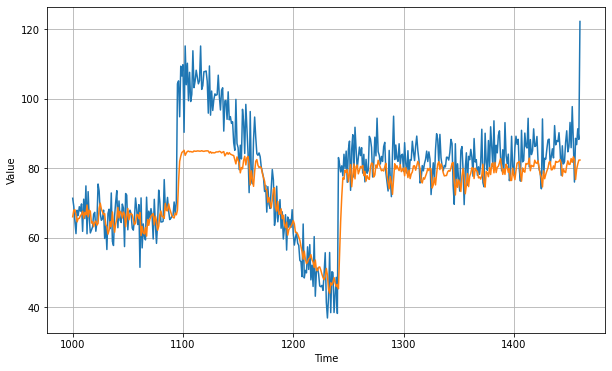

In [7]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

## Analyse

In [8]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.8195467

<Figure size 432x288 with 0 Axes>

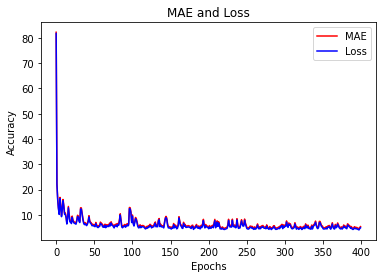

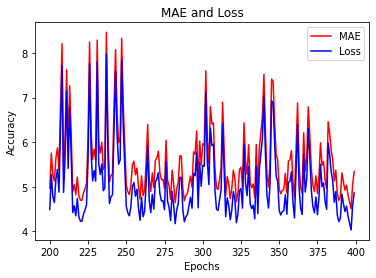

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## Conclusion

Cette courbe a été relativement bien prédite, malgré le fait que le modèle ait du mal à suivre lors de variations trop intenses.

En ce qui concerne l'entrainement, il sature assez rapidement, peut-etre que nous devons complexifier un peu le modèle.

Afin de mieux continuer, nous allons essayer de travailler sur des courbes encore plus simples afin de comprendre l'influence de chaque paramètre.